## Setup

In [60]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [61]:
CONTEXT_WINDOW = 200  # words to display for context

## Define Search Phrases

We'll analyze the following key phrases in press briefings:
Deport
America First
Ukraine
Israel
DOGE / Department of Government Efficiency / Doge
Russia
Elon / Musk
Inflation
Fraud
Intelligence
Crypto
Lawsuit
Egg
GM
Interest Rate
CBS
Ford
Chrysler
Debt Ceiling
Sylvester / Turner

In [62]:
SEARCH_PHRASES = {
    'Medicaid / Medicare': r'\b(medicaid|medicaids|medicaid\'s|medicaids\'|medicaid-\w+|\w+-medicaid|medicare|medicares|medicare\'s|medicares\'|medicare-\w+|\w+-medicare)\b',
    'Elon / Musk': r'\b(elon|elons|elon\'s|elons\'|elon-\w+|\w+-elon|musk|musks|musk\'s|musks\'|musk-\w+|\w+-musk)\b',
    'Worker': r'\b(worker|workers|worker\'s|workers\'|worker-\w+|\w+-worker)\b',
    'Housing': r'\b(housing|housings|housing\'s|housings\'|housing-\w+|\w+-housing)\b',
    'Billionaire': r'\b(billionaire|billionaires|billionaire\'s|billionaires\'|billionaire-\w+|\w+-billionaire)\b',
    'Bezos': r'\b(bezos|bezoss|bezos\'s|bezoss\'|bezos-\w+|\w+-bezos)\b',
    'Climate': r'\b(climate|climates|climate\'s|climates\'|climate-\w+|\w+-climate)\b',
    'Greed': r'\b(greed|greeds|greed\'s|greeds\'|greed-\w+|\w+-greed)\b',
    'Trump': r'\b(trump|trumps|trump\'s|trumps\'|trump-\w+|\w+-trump)\b',
    'ICE / Immigration and Customs Enforcement': r'\b(ice|ices|ice\'s|ices\'|ice-\w+|\w+-ice|immigration\s+and\s+customs\s+enforcement|immigration\s+and\s+customs\s+enforcements|immigration\s+and\s+customs\s+enforcement\'s|immigration\s+and\s+customs\s+enforcements\'|immigration-and-customs-enforcement|\w+-immigration-and-customs-enforcement)\b',
    'Corruption': r'\b(corruption|corruptions|corruption\'s|corruptions\'|corruption-\w+|\w+-corruption)\b',
    'Corrupt': r'\b(corrupt|corrupts|corrupt\'s|corrupts\'|corrupt-\w+|\w+-corrupt)\b',
    'Veteran': r'\b(veteran|veterans|veteran\'s|veterans\'|veteran-\w+|\w+-veteran)\b',
    'Epstein': r'\b(epstein|epsteins|epstein\'s|epsteins\'|epstein-\w+|\w+-epstein)\b',
    'AI / Artificial Intelligence': r'\b(ai|ais|ai\'s|ais\'|ai-\w+|\w+-ai|artificial\s+intelligence|artificial\s+intelligences|artificial\s+intelligence\'s|artificial\s+intelligences\'|artificial-intelligence|\w+-artificial-intelligence)\b',
    'Tariff': r'\b(tariff|tariffs|tariff\'s|tariffs\'|tariff-\w+|\w+-tariff)\b',
    'Big Beautiful Bill': r'\b(big\s+beautiful\s+bill|big\s+beautiful\s+bills|big\s+beautiful\s+bill\'s|big\s+beautiful\s+bills\'|big-beautiful-bill|\w+-big-beautiful-bill)\b',
    'Oligarchy': r'\b(oligarchy|oligarchies|oligarchy\'s|oligarchies\'|oligarchy-\w+|\w+-oligarchy)\b',
    'Alexandria': r'\b(alexandria|alexandrias|alexandria\'s|alexandrias\'|alexandria-\w+|\w+-alexandria)\b',
    'DOGE': r'\b(doge|doges|doge\'s|doges\'|doge-\w+|\w+-doge)\b',
    'Autopen': r'\b(autopen|autopens|autopen\'s|autopens\'|autopen-\w+|\w+-autopen)\b'
}

In [63]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format ...YYYYMMDD.txt"""
    # Split by '.' and get the date part (last part before .txt)
    parts = filename.split('.')
    if len(parts) >= 2:
        date_str = parts[-2]  # Get the part before .txt
        return datetime.strptime(date_str, '%Y%m%d')
    else:
        raise ValueError(f"Could not extract date from filename: {filename}")

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process all transcript files in directory"""
    results = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    return pd.DataFrame(results)

In [64]:
# Process press briefing transcripts
df = process_directory('../data-bernie')
df = df.sort_values('date')

# Print dataset statistics
print("Dataset Statistics:")
print(f"Total briefings: {len(df)}")

print("\nWord Count Statistics:")
print(f"Average length: {df['text_length'].mean():.0f} words")

print("\nDate Range:")
# Handle NaT values when printing date ranges
date_min = df['date'].min()
date_max = df['date'].max()
if pd.notna(date_min) and pd.notna(date_max):
    print(f"{date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
else:
    print("No valid dates")

Dataset Statistics:
Total briefings: 16

Word Count Statistics:
Average length: 3916 words

Date Range:
2025-03-20 to 2025-06-23


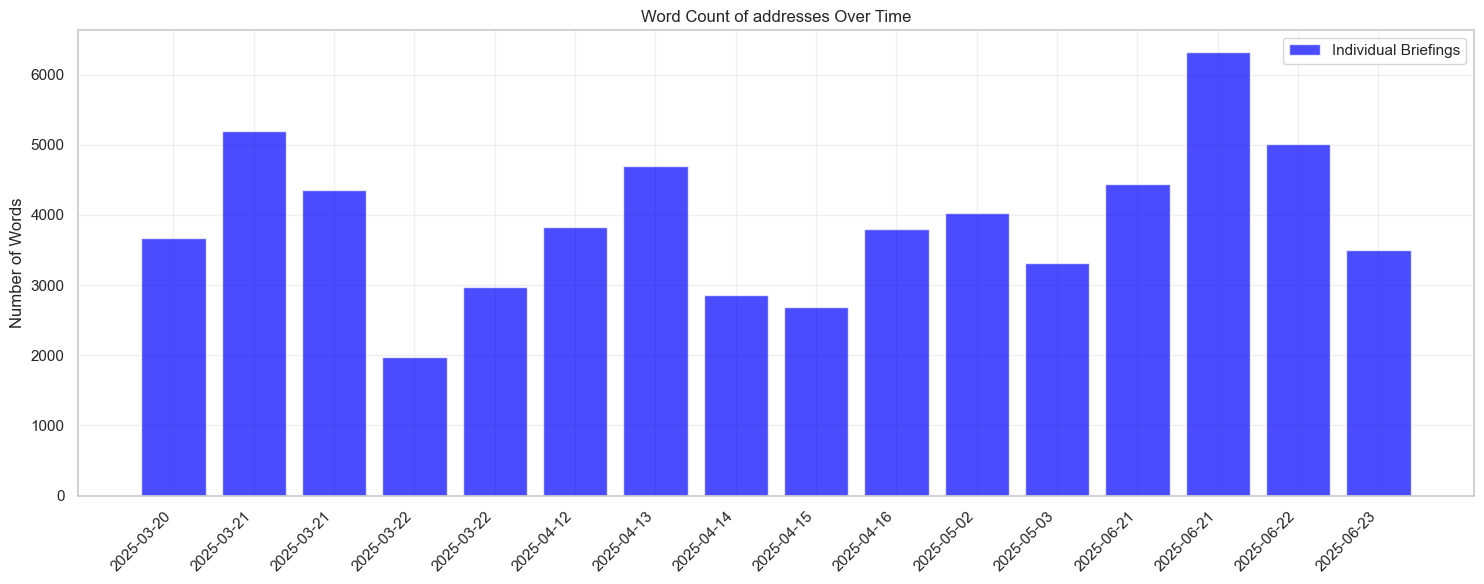


Word Count Summary:
Mean word count: 3916
Median word count: 3816
Min word count: 1973
Max word count: 6314


In [70]:
# Plot total word counts over time as a bar chart
plt.figure(figsize=(15, 6))

# Sort dataframe by date to ensure proper ordering
df_sorted = df.sort_values('date')

# Create sequential x positions for side-by-side plotting
x_positions = range(len(df_sorted))

# Create bar plot with sequential positions
bars = plt.bar(x_positions, df_sorted['text_length'], alpha=0.7, color='blue', label='Individual Briefings')

# Format x-axis with date labels at sequential positions
plt.xticks(x_positions, [d.strftime('%Y-%m-%d') for d in df_sorted['date']], rotation=45, ha='right')

plt.title('Word Count of addresses Over Time')
plt.xlabel('') # Remove x-axis label since dates are shown
plt.ylabel('Number of Words')
plt.legend()
plt.grid(True, alpha=0.3)

# Set y-axis to start at 0
plt.ylim(bottom=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nWord Count Summary:")
print(f"Mean word count: {df['text_length'].mean():.0f}")
print(f"Median word count: {df['text_length'].median():.0f}")
print(f"Min word count: {df['text_length'].min():.0f}")
print(f"Max word count: {df['text_length'].max():.0f}")


## Phrase Frequency Analysis

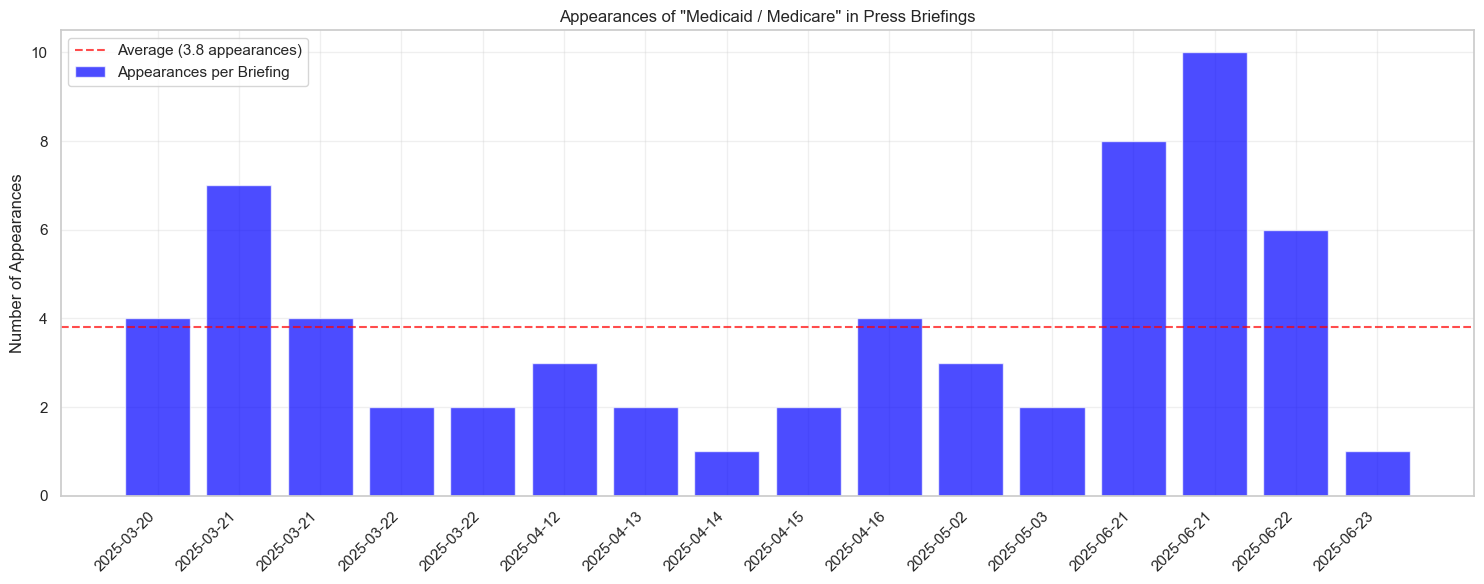

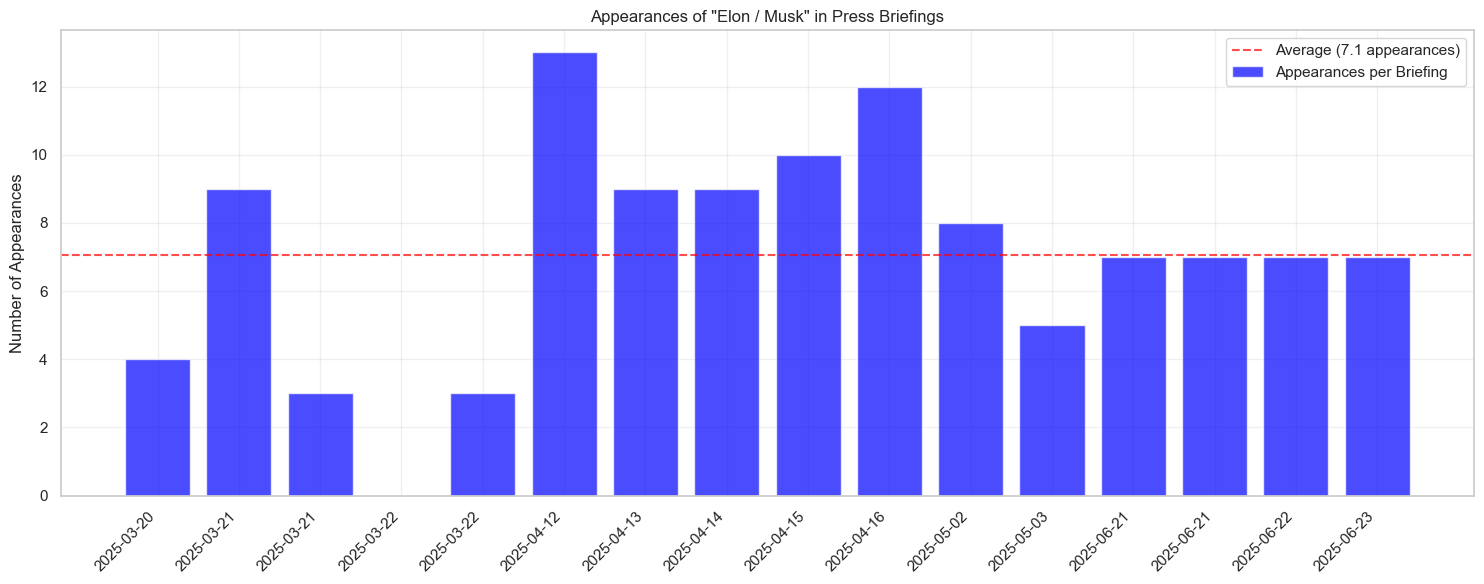

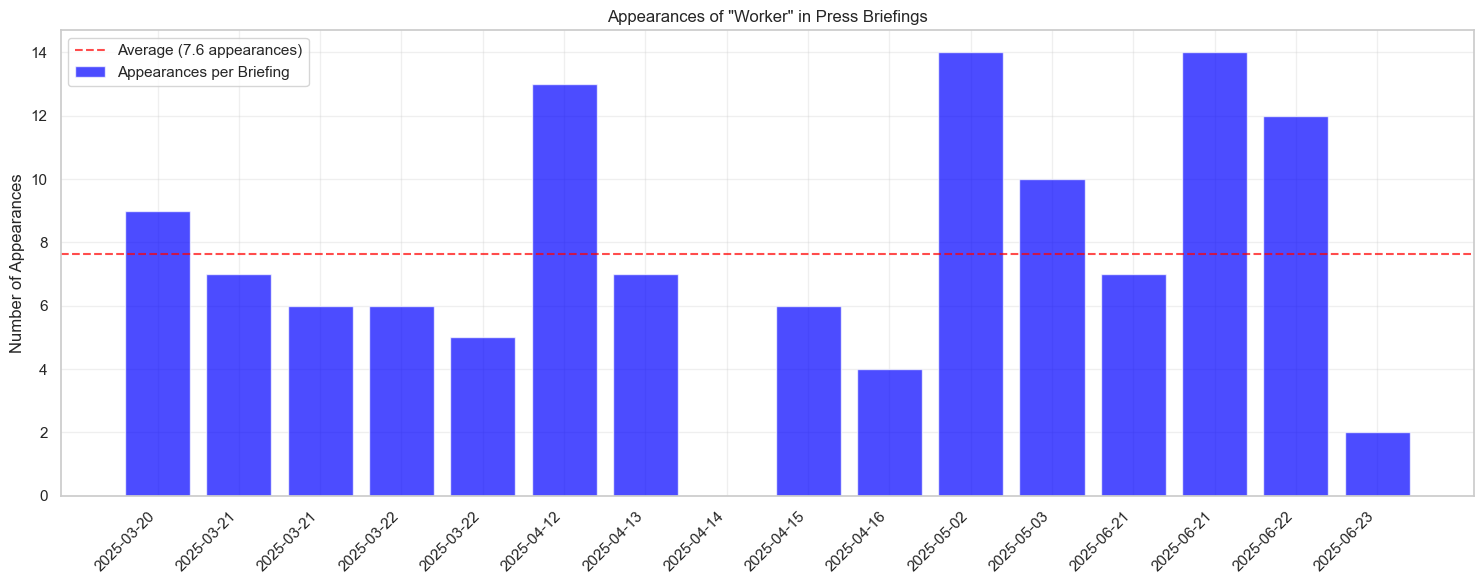

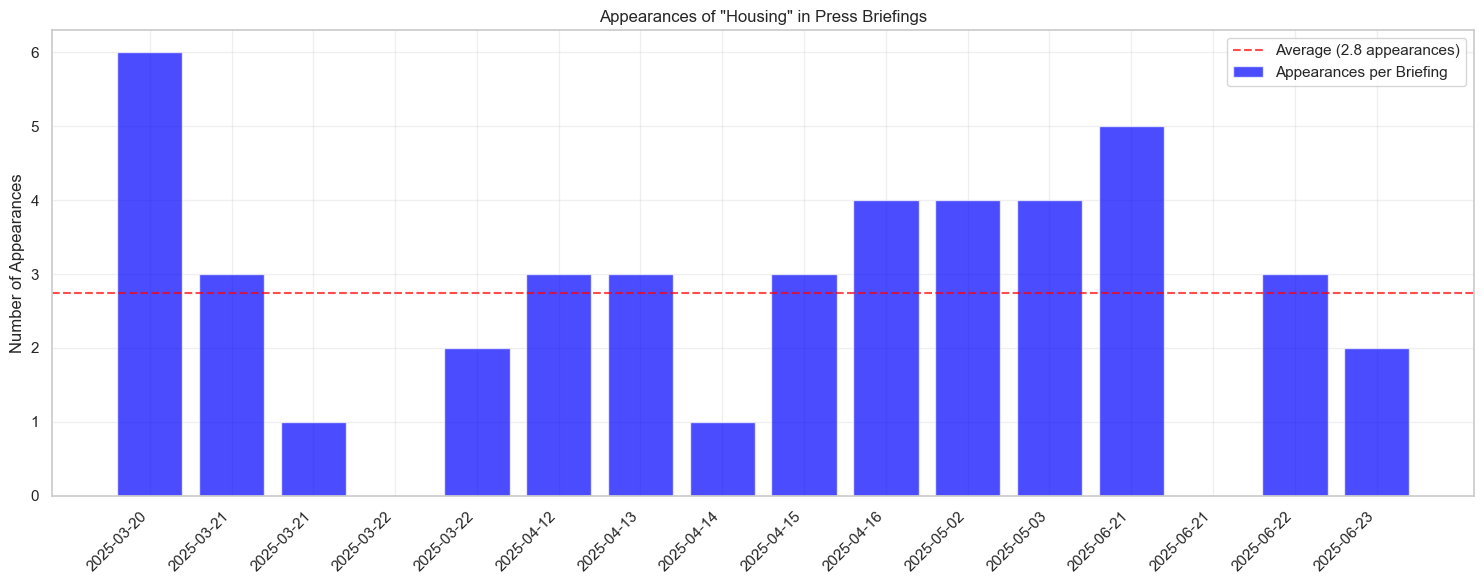

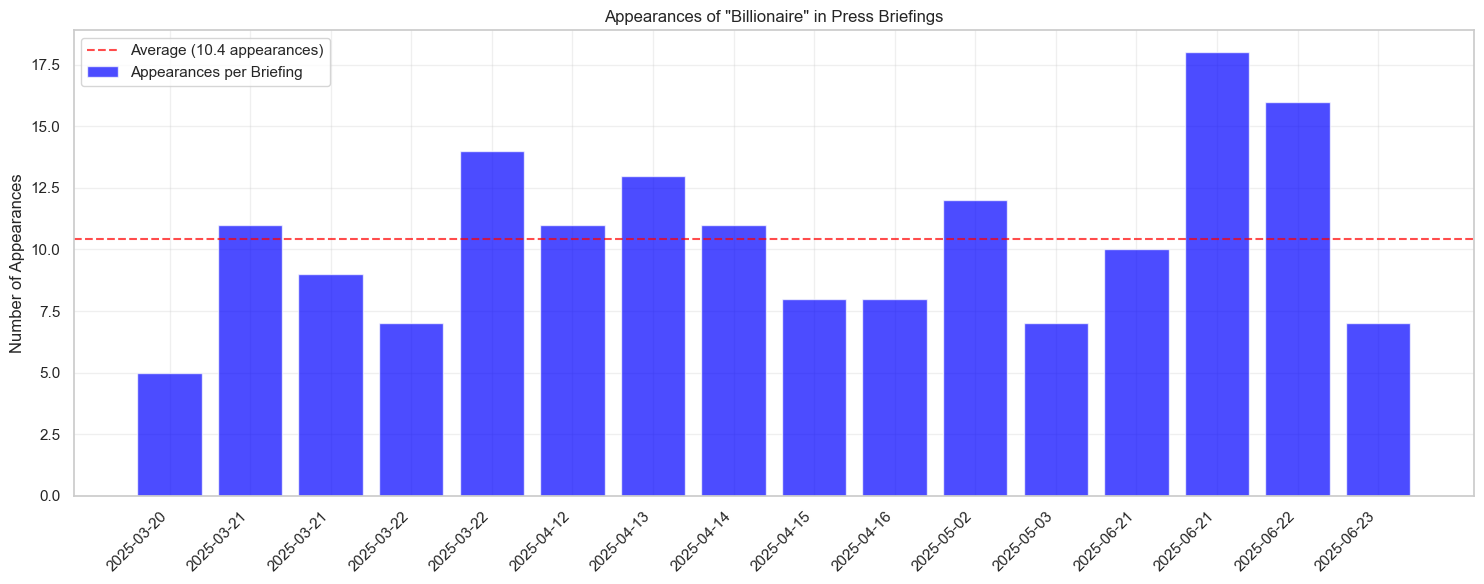

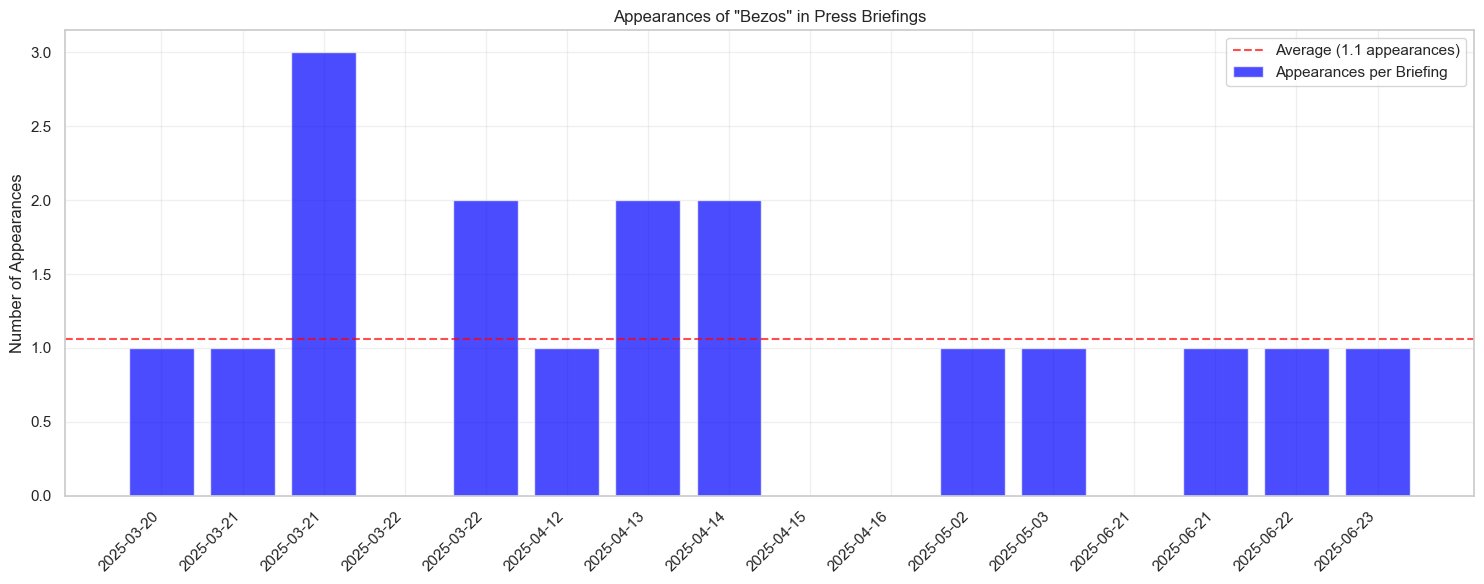

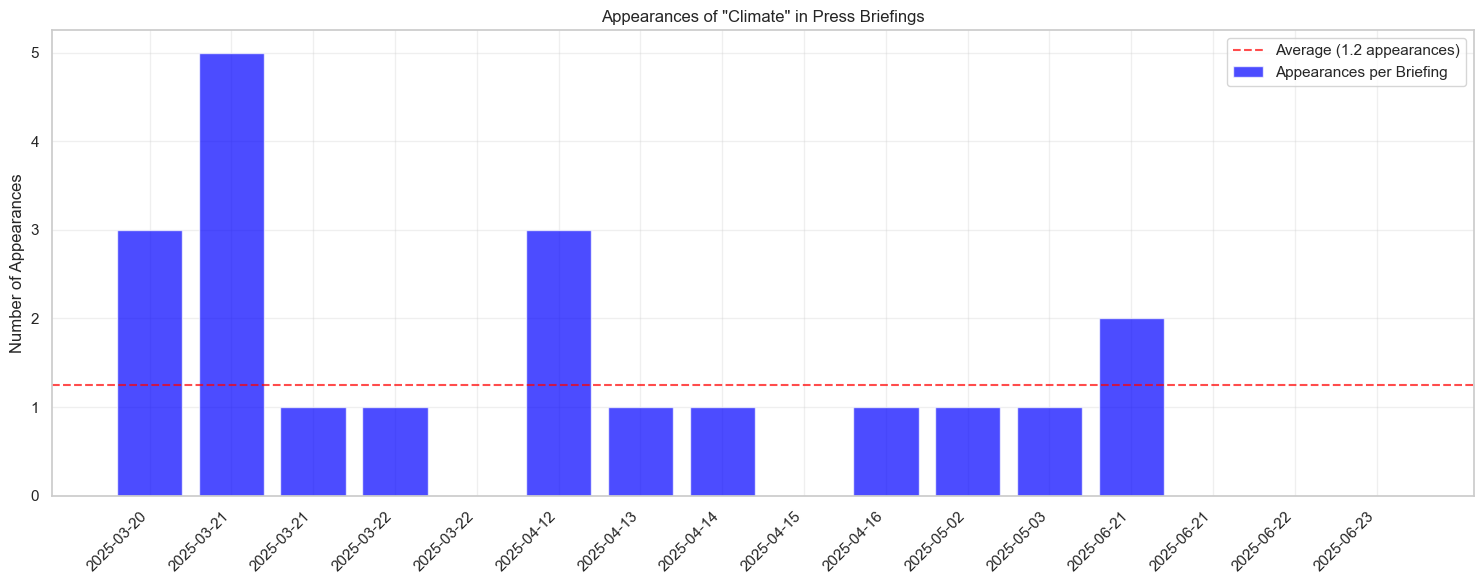

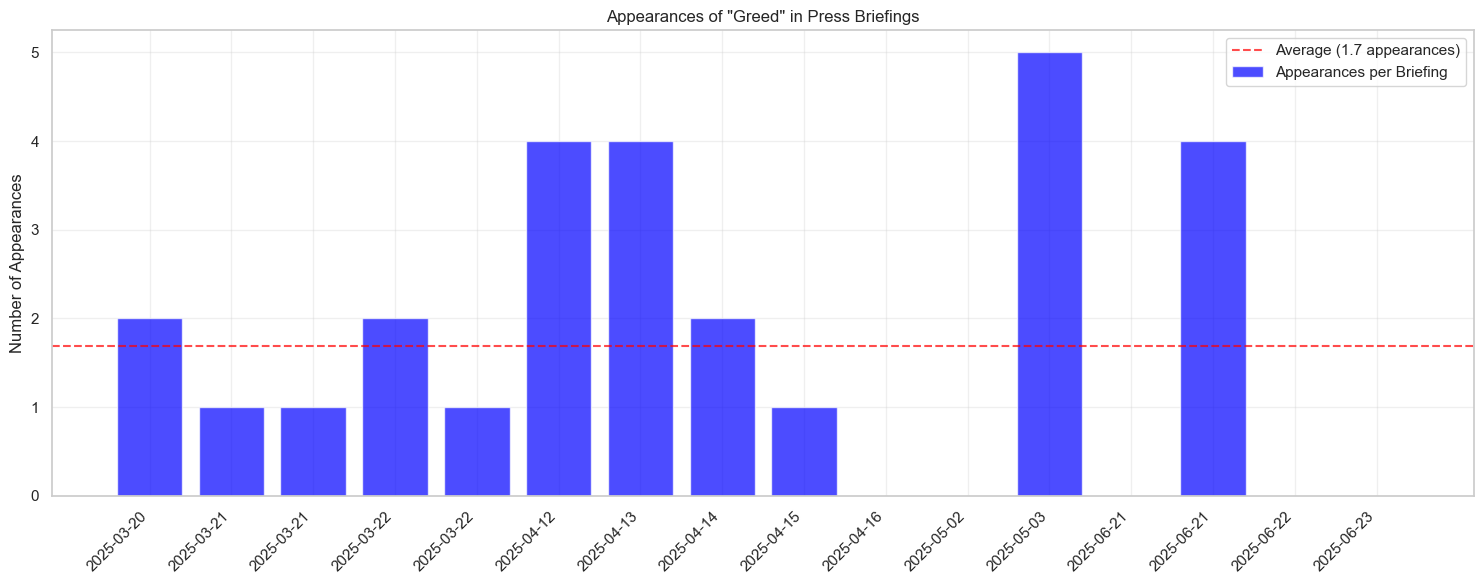

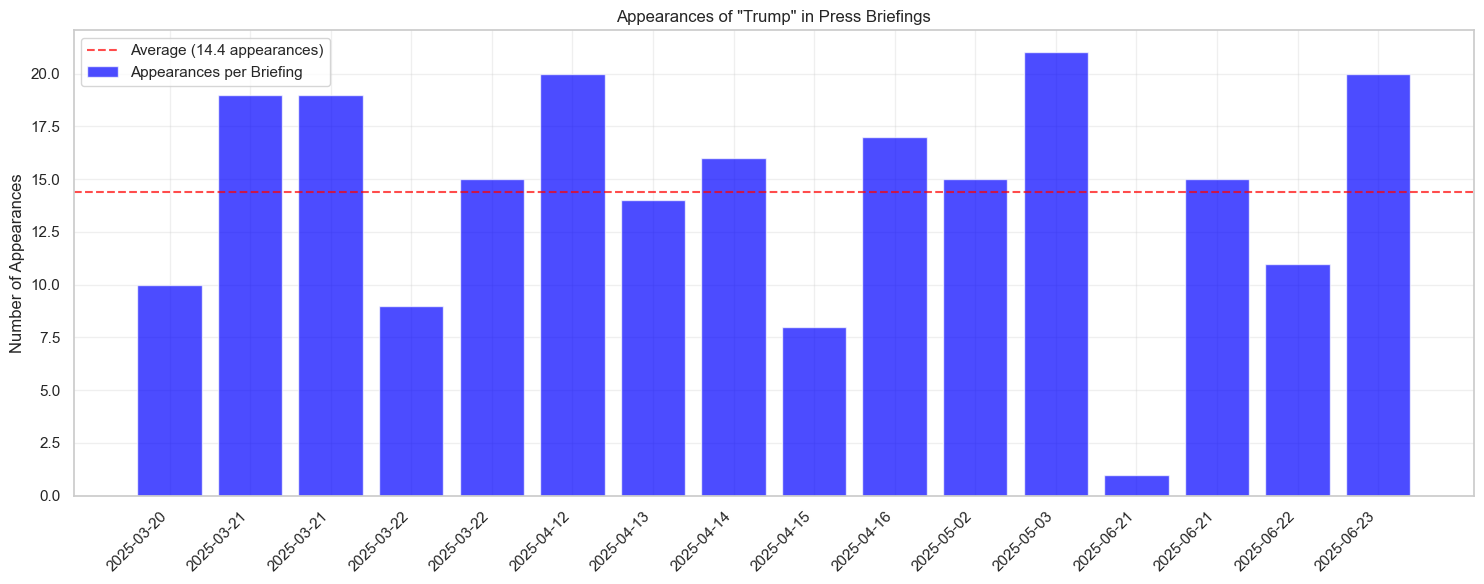

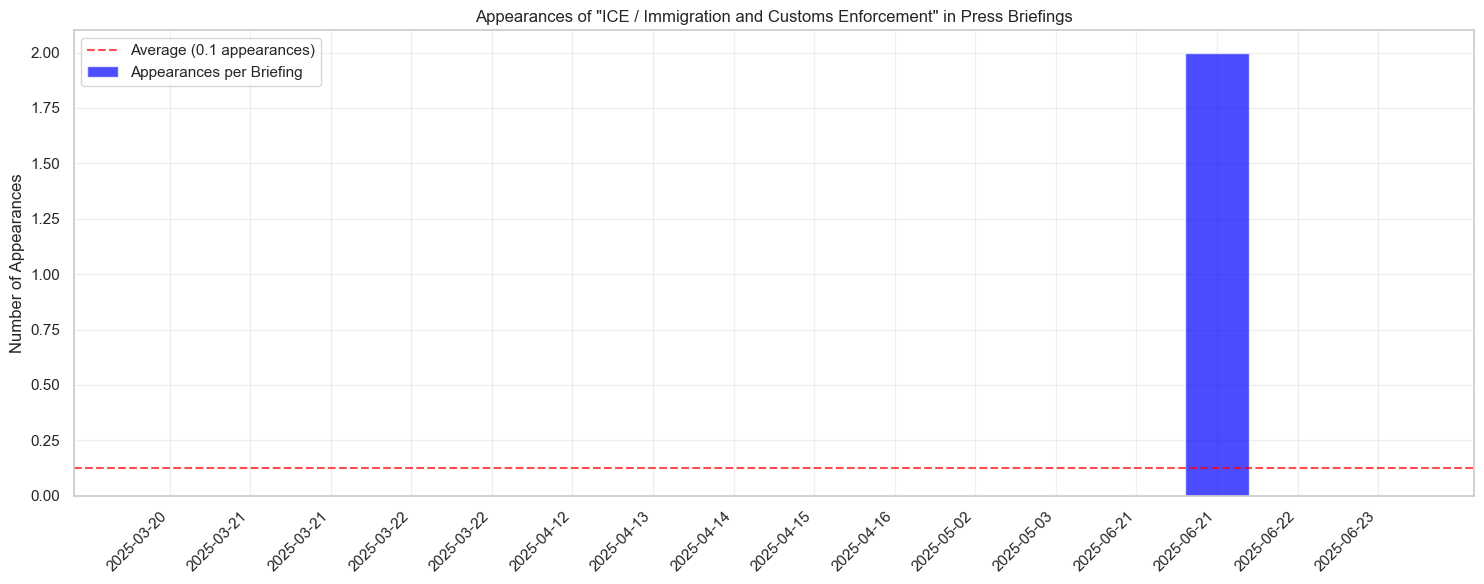

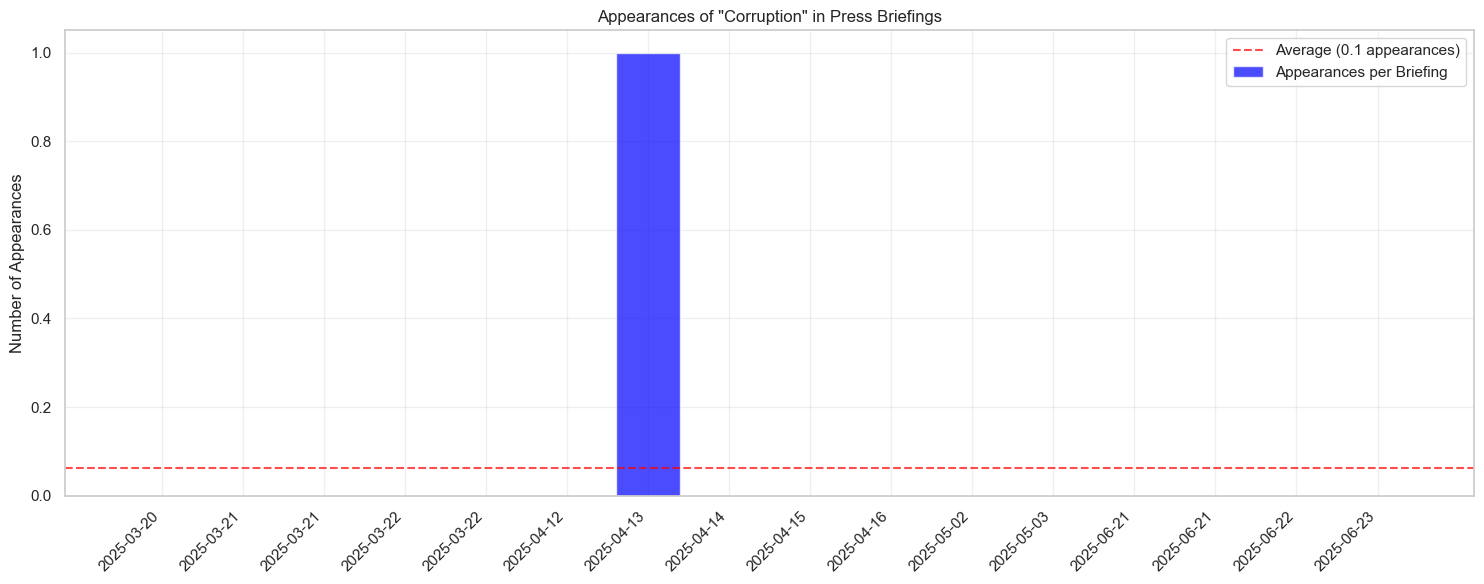

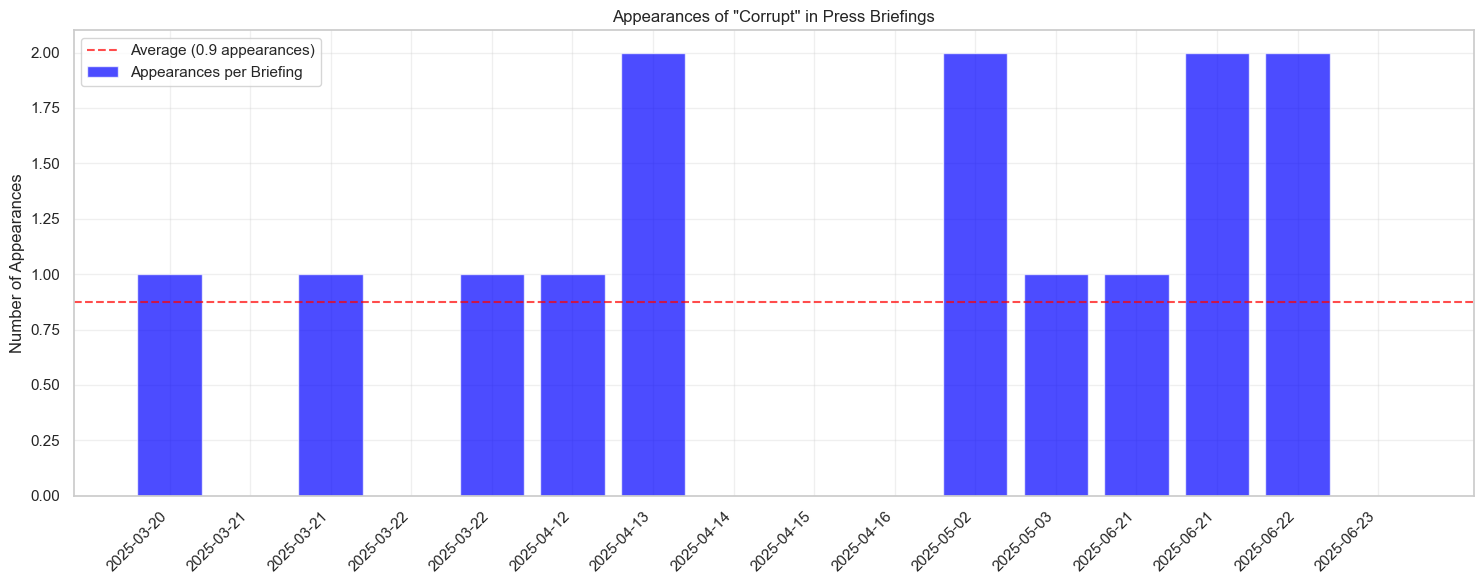

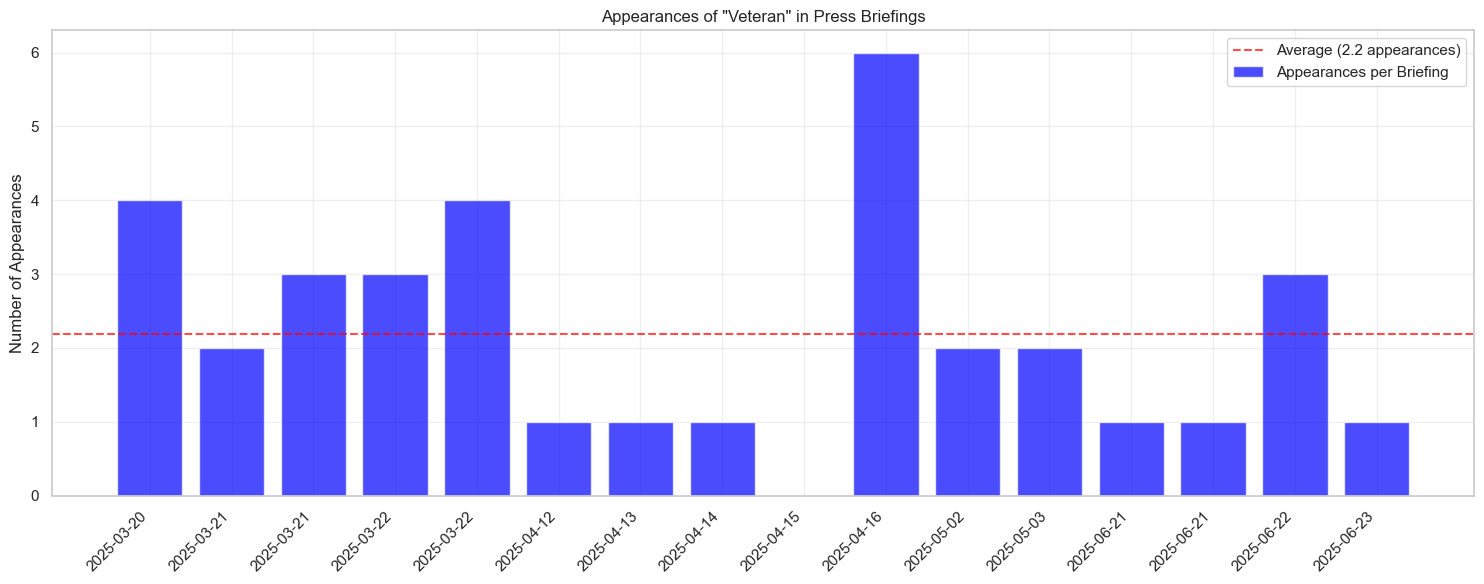

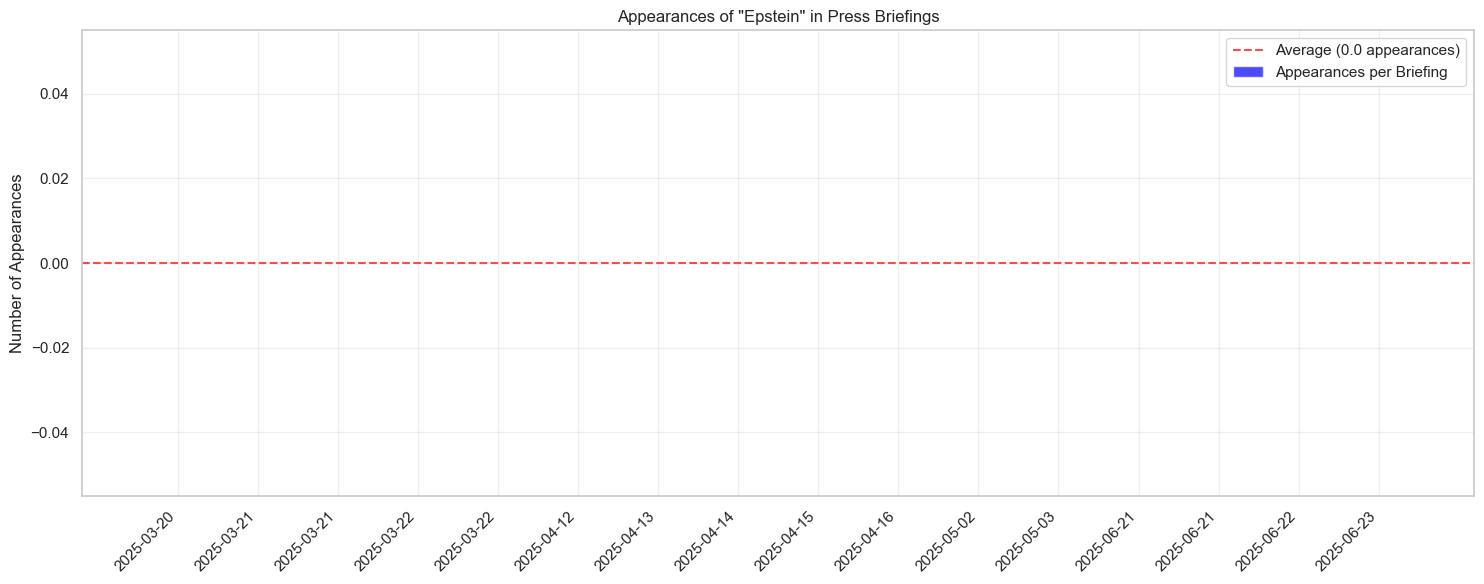

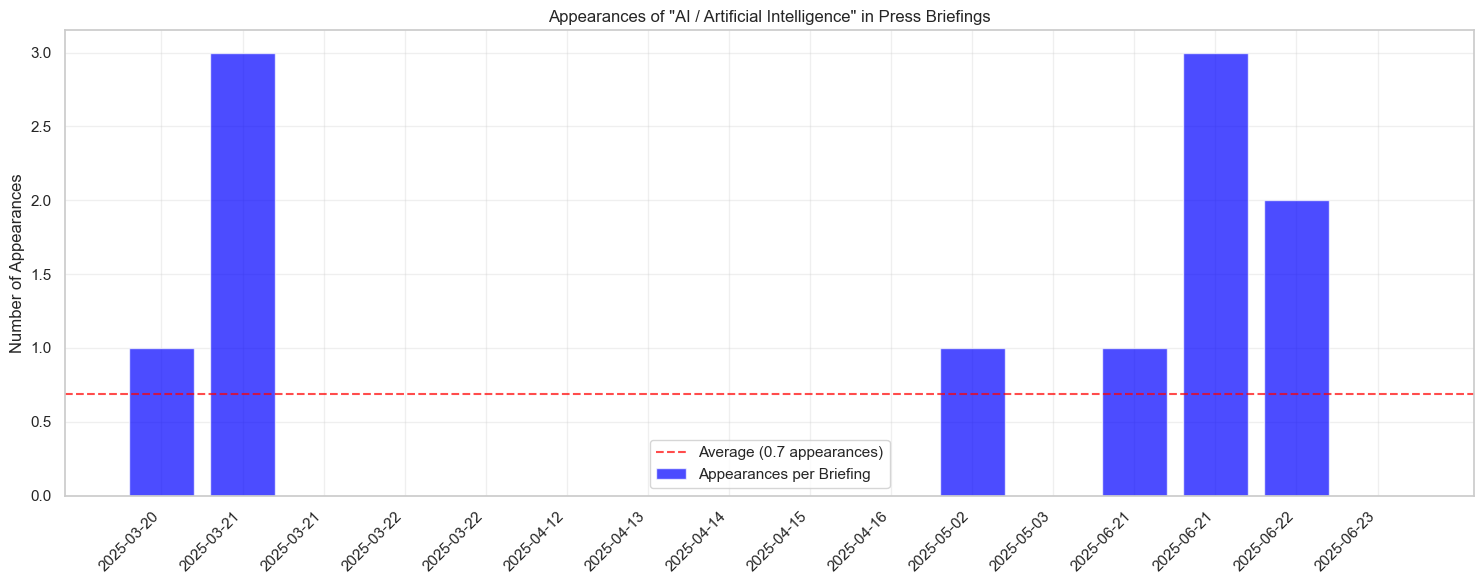

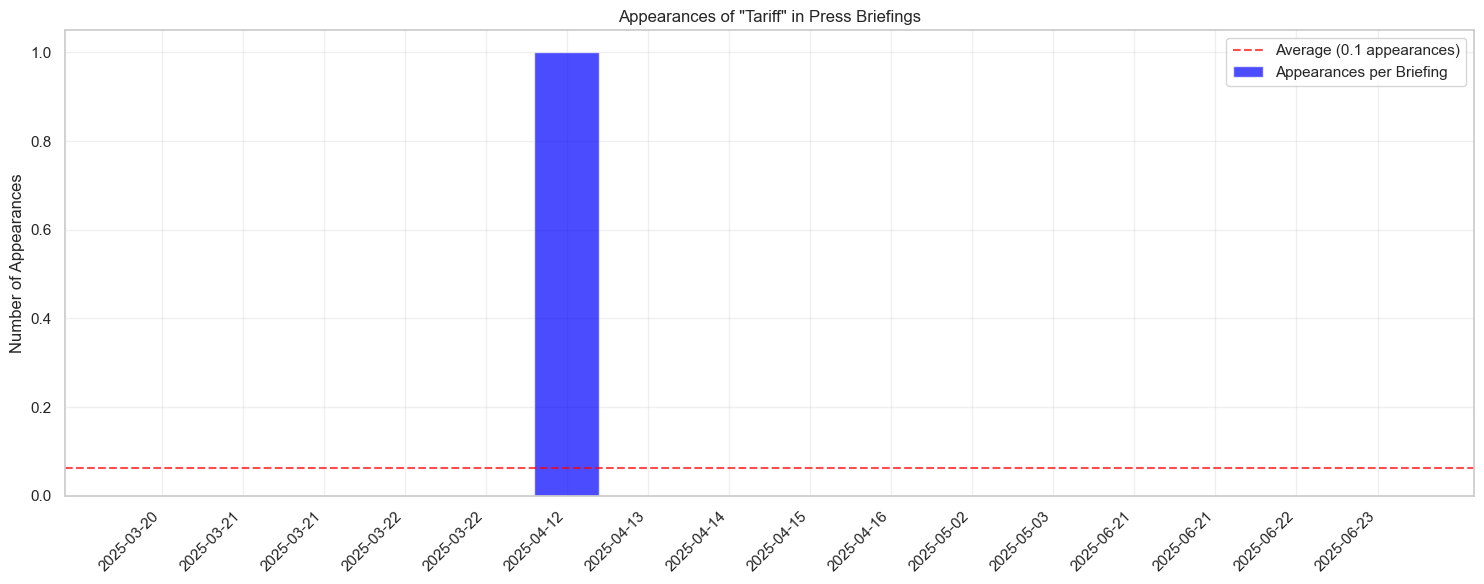

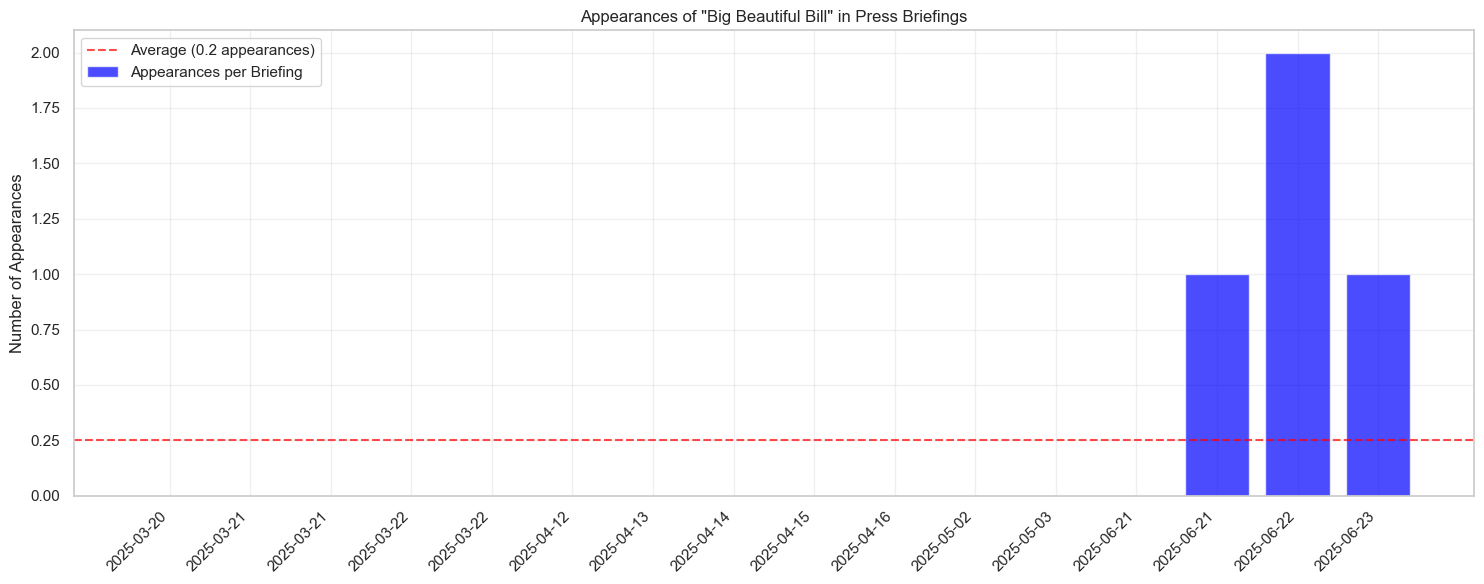

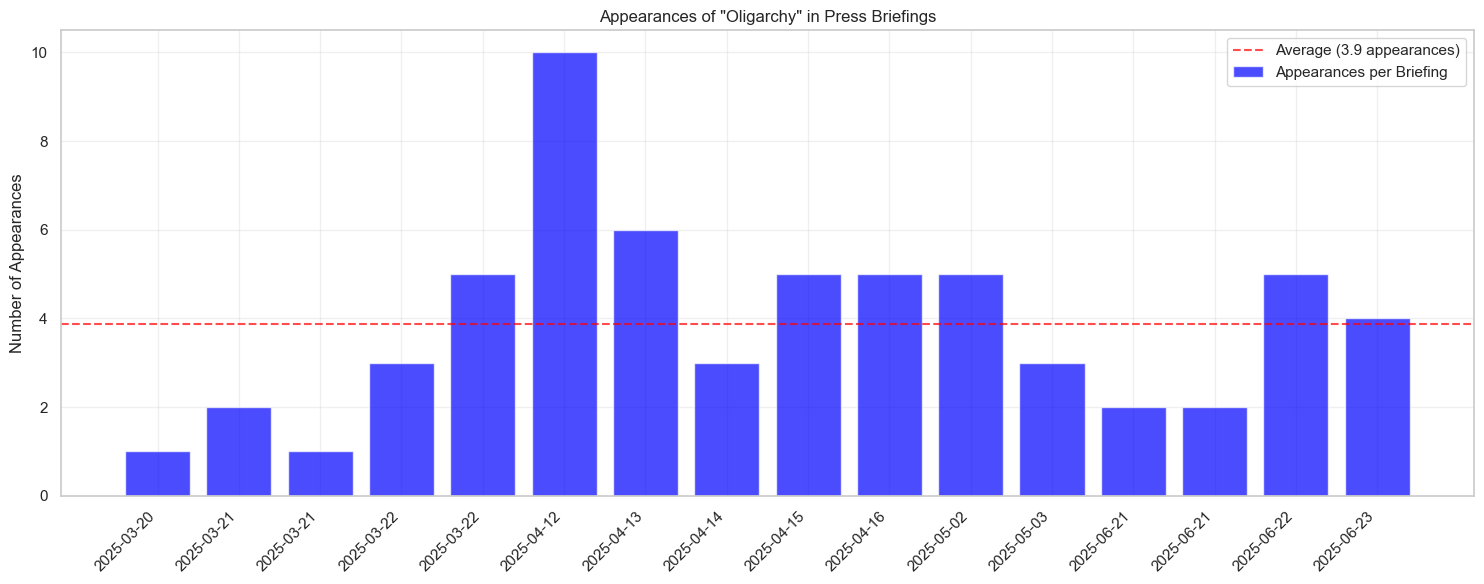

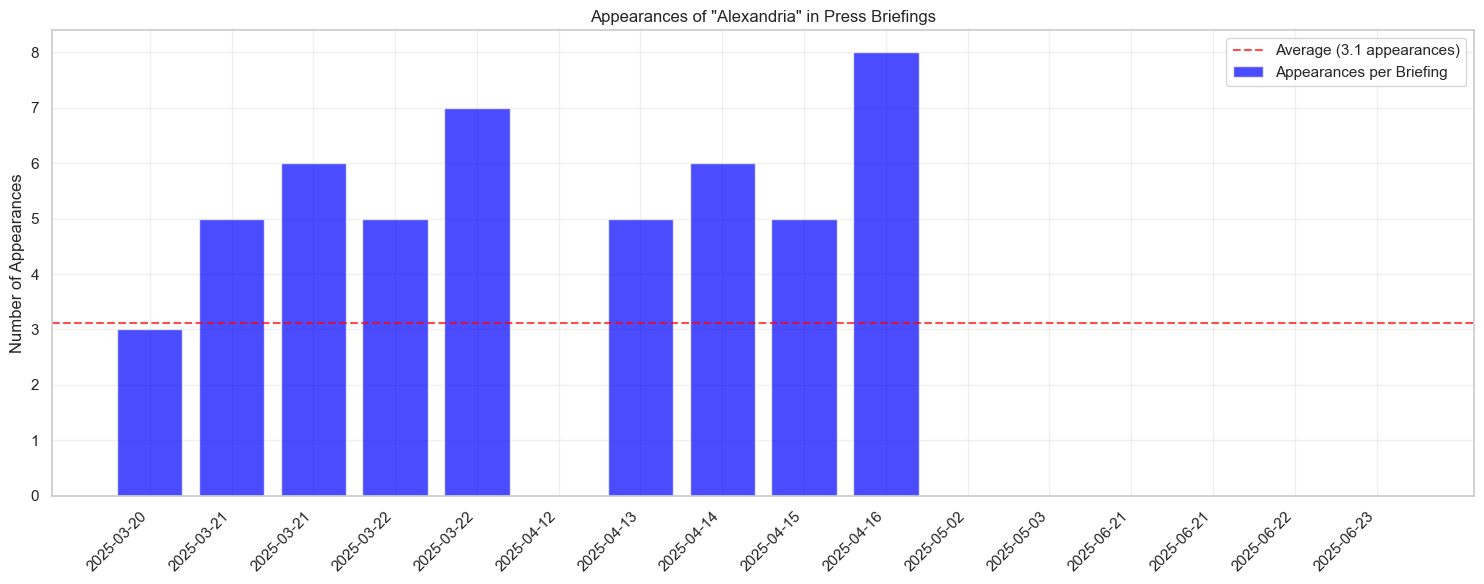

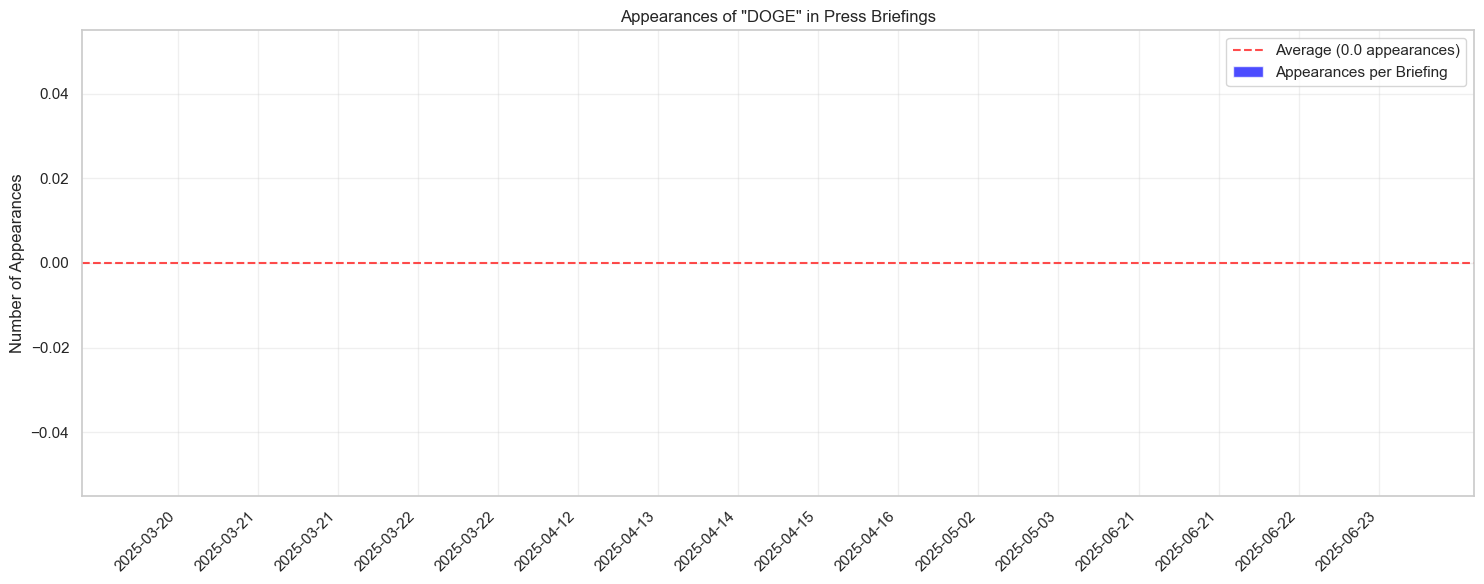

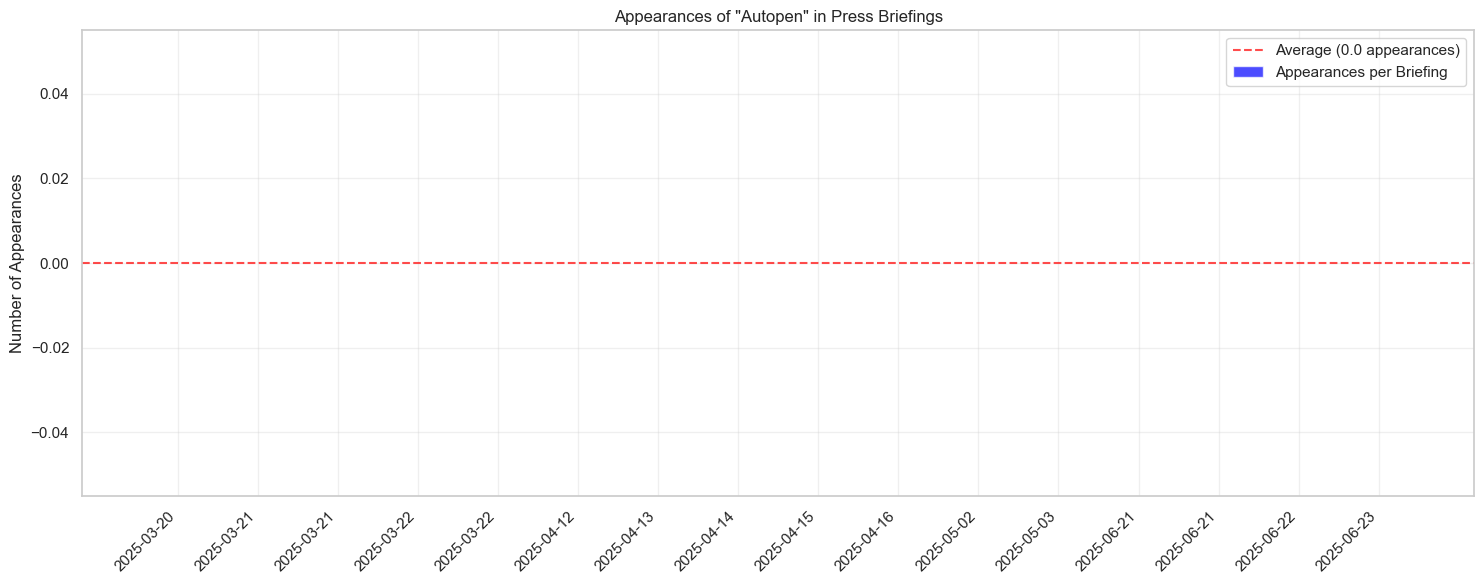

In [66]:
def plot_phrase_frequency_over_time(df, phrase):
    """Plot the frequency of a phrase over time"""
    plt.figure(figsize=(15, 6))
    
    # Get raw counts and dates, sorted by date
    df_sorted = df.sort_values('date')
    counts = df_sorted[phrase]
    dates = df_sorted['date']
    
    # Calculate average
    avg = counts.mean()
    
    # Create sequential x positions (0, 1, 2, 3, ...)
    x_positions = range(len(counts))
    
    # Create bar plot with sequential positions
    bars = plt.bar(x_positions, counts, alpha=0.7, color='blue', 
                   label='Appearances per Briefing')
    
    # Add horizontal line for average
    plt.axhline(y=avg, color='red', linestyle='--', alpha=0.7, 
                label=f'Average ({avg:.1f} appearances)')
    
    # Format x-axis with date labels at sequential positions
    plt.xticks(x_positions, [d.strftime('%Y-%m-%d') for d in dates], 
               rotation=45, ha='right')
    
    plt.title(f'Appearances of "{phrase}" in Press Briefings')
    plt.xlabel('')  # Remove x-axis label since dates are shown
    plt.ylabel('Number of Appearances')
    plt.legend()
    plt.grid(True, alpha=0.3)

    
    plt.tight_layout()
    plt.show()

# Plot time series for all phrases
for phrase in SEARCH_PHRASES.keys():
    plot_phrase_frequency_over_time(df, phrase)

## Recent Usage in Context

In [67]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    all_matches = []
    
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')}")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Medicaid / Medicare' ===

Date: 2025-06-23
Context: ... big
beautiful bill
this bill would give $650 billion dollar in tax breaks to the 1%
[Applause] 400 billion to large corporations in tax
breaks and to pay for it they're going to make
massive cuts in Medicaid nutrition and education
[Applause] you know
I don't know how people could sleep at night by voting for a bill which gives
$200 billion in tax breaks to the top 210 of 1%
and then and then takes food ...

Date: 2025-06-22
Context: ...aks to the 1%
and you give away 400 billion to large profitable corporations how you going to pay for it and this is what is really
quite disgusting and outrageous about this bill
This bill would cut Medicaid and the Affordable Care Act by over $1 trillion
And what does that mean what does that mean how does it impact you well it impacts Americans because the
Congressional Budget Office which is a nonpart...

Date: 2025-06-22
Context: ...is a nonpartisan uh organization in Con

## Phrase Co-occurrence Analysis

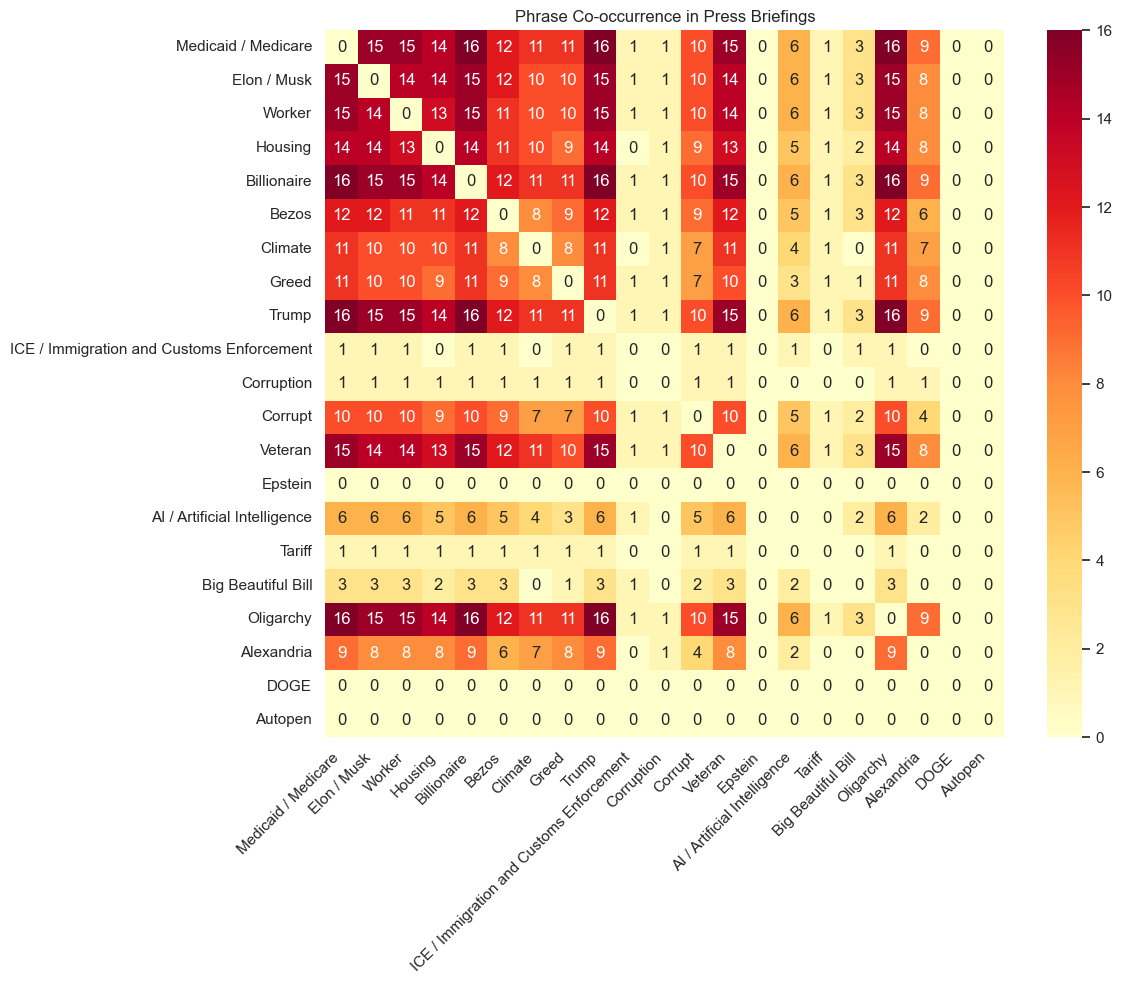

In [68]:
# Create co-occurrence matrix
phrase_cols = list(SEARCH_PHRASES.keys())
cooccurrence = np.zeros((len(phrase_cols), len(phrase_cols)))

for i, phrase1 in enumerate(phrase_cols):
    for j, phrase2 in enumerate(phrase_cols):
        if i != j:
            # Count briefings where both phrases appear
            cooccurrence[i,j] = ((df[phrase1] > 0) & (df[phrase2] > 0)).sum()

# Create and display heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, 
            xticklabels=phrase_cols,
            yticklabels=phrase_cols,
            annot=True,
            fmt='.0f',
            cmap='YlOrRd')
plt.title('Phrase Co-occurrence in Press Briefings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Phrase Usage Statistics

In [69]:
# Calculate statistics for each phrase
stats_data = []

for phrase in SEARCH_PHRASES.keys():
    stats = {
        'Phrase': phrase,
        'Total Mentions': df[phrase].sum(),
        'Briefings with Mentions': (df[phrase] > 0).sum(),
        'Percentage of Briefings': (df[phrase] > 0).mean() * 100,
        'Average per Briefing': df[phrase].mean(),
        'Max in Single Briefing': df[phrase].max()
    }
    stats_data.append(stats)

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Total Mentions', ascending=False)

# Format the table
stats_df['Percentage of Briefings'] = stats_df['Percentage of Briefings'].round(1).astype(str) + '%'
stats_df['Average per Briefing'] = stats_df['Average per Briefing'].round(2)

display(stats_df)

,Phrase,Total Mentions,Briefings with Mentions,Percentage of Briefings,Average per Briefing,Max in Single Briefing
8,Trump,230,16,100.0%,14.38,21
4,Billionaire,167,16,100.0%,10.44,18
2,Worker,122,15,93.8%,7.62,14
1,Elon / Musk,113,15,93.8%,7.06,13
17,Oligarchy,62,16,100.0%,3.88,10
0,Medicaid / Medicare,61,16,100.0%,3.81,10
18,Alexandria,50,9,56.2%,3.12,8
3,Housing,44,14,87.5%,2.75,6
12,Veteran,35,15,93.8%,2.19,6
7,Greed,27,11,68.8%,1.69,5
